<a href="https://colab.research.google.com/github/pswaruppk/GL_CAPSTONE/blob/master/classification_option1_InceptionResNetV2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Hybrid model
  This notebook is trying to build option-1 which includes classification followed by detection.

Classification:
  1. ChexNet- Densnet121 - This has been implemented here.
  2. VGG NET
  3. InceptionV3
  4. **InceptionRestNetV2** This has been implemented here

Detection:
  RetinaNet based architecture
  1. ResNet101 
  2. ResNet152

In [ ]:
import os

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
project_path = "/content/drive/My Drive/rsna-pneumonia-detection-challenge"
os.chdir(project_path)
os.getcwd()

'/content/drive/My Drive/rsna-pneumonia-detection-challenge'

## Model Parameters

In [ ]:
#Set global parameters here
BASE_MODEL = "InceptionResNetV2"
MODEL_NAME  = "Option-1" + "." + BASE_MODEL
if os.path.isdir(MODEL_NAME) == False:
  os.mkdir(MODEL_NAME)
WEIGHTS_FILE = MODEL_NAME+"/" + "weights.best_299_final1.h5"
HISTORY_FILE = MODEL_NAME+"/" +"history_299_final_1.csv"
PREDICTION_FILE = MODEL_NAME+"/" + "prediction_final1.pkl"
BATCH_SIZE = 32
IMAGE_SIZE = 299 #target image width
IMG_WIDTH = 1024 #Original image width
FORCE_TRAINING = False #True , change it to force training
DROPOUT = 0.25 # [0, 0.25, 0.5]
DENSE_COUNT = 128 # [32, 64, 128, 256]
LEARN_RATE = 1e-4 # [1e-4, 1e-3, 4e-3]
ALPHA = 1.0
EPOCHS = 6

In [ ]:
oldPath = os.getcwd()
utility_path = "/content/drive/My Drive/GL_CAPSTONE"
os.chdir(utility_path)
%run pneumonia_utility.ipynb
baseModel,preprocess_input = selectBaseModel(BASE_MODEL)
os.chdir(oldPath)
print(os.getcwd())
print(baseModel,preprocess_input)

Loading functions from Pneumonia utility notebook
Loading pydicom package
     |████████████████████████████████| 35.5MB 90kB/s 
Setting baseModel : InceptionResNetV2
<module 'tensorflow.keras.applications.inception_resnet_v2' from '/usr/local/lib/python3.6/dist-packages/tensorflow/keras/applications/inception_resnet_v2/__init__.py'>
global BaseModel; BaseModel =np.InceptionResNetV2
global preprocess_input; preprocess_input =np.preprocess_input
<class 'function'>
/content/drive/My Drive/rsna-pneumonia-detection-challenge
<function InceptionResNetV2 at 0x7fb48299c840> <function preprocess_input at 0x7fb48299c9d8>


In [ ]:
baseModel,preprocess_input

(<function tensorflow.python.keras.applications.inception_resnet_v2.InceptionResNetV2>,
 <function tensorflow.python.keras.applications.inception_resnet_v2.preprocess_input>)

In [ ]:
shape = MODEL_MAP[BASE_MODEL]['input_shape']
IMAGE_SIZE = shape[0]
print('{}:IMAGE_SIZE, {}:Model Input Shape'.format(IMAGE_SIZE,shape))

299:IMAGE_SIZE, (299, 299, 3):Model Input Shape


In [ ]:
#Loading full data
full_df,bbox_map,class_enc = loadData()

Loading full CXR info
Loading bbox map


In [ ]:

# CLASS_VECTORS = get_class_map(full_df)

In [ ]:
full_df.head(2)

,Unnamed: 0,patientId,x,y,width,height,Target,BboxNo,PatientAge,PatientSex,ViewPosition,class,class_id,class_vector,path
0,0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0,1,51,0,0,No Lung Opacity / Not Normal,1,"[0.0, 1.0, 0.0]",stage_2_train_images/0004cfab-14fd-4e49-80ba-6...
1,1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0,1,48,0,0,No Lung Opacity / Not Normal,1,"[0.0, 1.0, 0.0]",stage_2_train_images/00313ee0-9eaa-42f4-b0ab-c...


In [ ]:
full_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30227 entries, 0 to 30226
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Unnamed: 0    30227 non-null  int64  
 1   patientId     30227 non-null  object 
 2   x             9555 non-null   float64
 3   y             9555 non-null   float64
 4   width         9555 non-null   float64
 5   height        9555 non-null   float64
 6   Target        30227 non-null  int64  
 7   BboxNo        30227 non-null  int64  
 8   PatientAge    30227 non-null  int64  
 9   PatientSex    30227 non-null  int64  
 10  ViewPosition  30227 non-null  int64  
 11  class         30227 non-null  object 
 12  class_id      30227 non-null  int64  
 13  class_vector  30227 non-null  object 
 14  path          30227 non-null  object 
dtypes: float64(4), int64(7), object(4)
memory usage: 3.5+ MB


In [ ]:
full_df.drop(full_df.columns[0],inplace=True,axis=1)

In [ ]:
print('{}:Total Pneumonia Patient'.format(len(full_df[full_df.Target == 1])))

9555:Total Pneumonia Patient


In [ ]:
#Split the dataset  into 3 train/valid/test
unbalanced_train_df, valid_df, test_df = splitData(full_df,target='class')

(21347, 14) training data
(5337, 14) raw validation data
(2668, 14) Validation data
(2669, 14) test data


In [ ]:
unbalanced_train_df[unbalanced_train_df.class_id == 0].shape[0]

4809

12624 Final training size


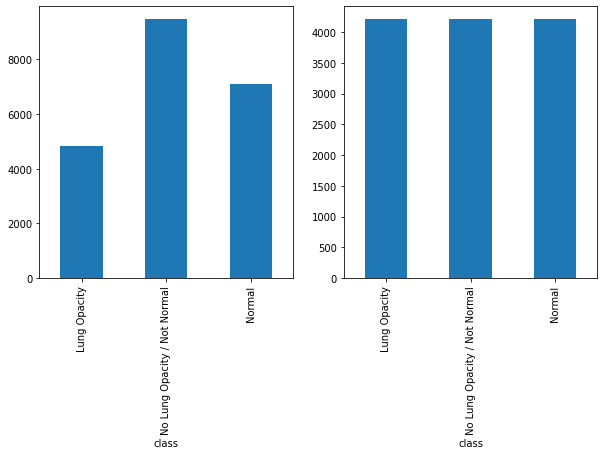

In [ ]:
import matplotlib.pyplot as plt
TRAIN_SAMPLES = 12624 # 4208 x 3 class targets
#Balancing training set
train_df = balance_df(unbalanced_train_df,TRAIN_SAMPLES,target='class')
print(train_df.shape[0], 'Final training size')

In [ ]:
# train_df.to_csv('classification_train_df.csv',index=False)
# valid_df.to_csv('classification_valid_df.csv',index=False)
# test_df.to_csv('classification_test_df.csv',index=False)
train_df = pd.read_csv('classification_train_df.csv',converters={'class_vector':eval})
valid_df = pd.read_csv('classification_valid_df.csv',converters={'class_vector':eval})
test_df = pd.read_csv('classification_test_df.csv',converters={'class_vector':eval})

In [ ]:
y = train_df.class_vector[0]

In [ ]:
type(y)

list

## Build model

In [ ]:
len(np.unique(train_df["path"].to_numpy()))

12624

In [ ]:
# BATCH_SIZE = 8
# IMAGE_SIZE = 224
# IMG_WIDTH = 1024
train_gen = MyLabelDataGenerator(train_df,augment= True)
valid_gen = MyLabelDataGenerator(valid_df,augment= True)

print(len(train_gen), "# of iterations in one train epoch")
print(len(valid_gen), "# of iterations in one validate epoch")

12624 :No of generator Image
2668 :No of generator Image
394 # of iterations in one train epoch
83 # of iterations in one validate epoch


In [ ]:
Set = 0
imageSet = train_gen[Set][0]
maskSet = train_gen[Set][1]   #Label

In [ ]:
imageSet.shape,maskSet.shape

((32, 299, 299, 3), (32, 3))

In [ ]:
SetIndex = 0
imageIndex = Set*BATCH_SIZE + SetIndex
path = train_gen.filenames[imageIndex]
img = train_gen.getImage(path)

- We are showing a sample image below which is before and after preprocessing. This gives us idea as to how the transformation is done by the preprocess_input package of the selected model before feeding it to the model. 

Text(0.5, 1.0, 'Pre-Processed:Label:[1. 0. 0.]')

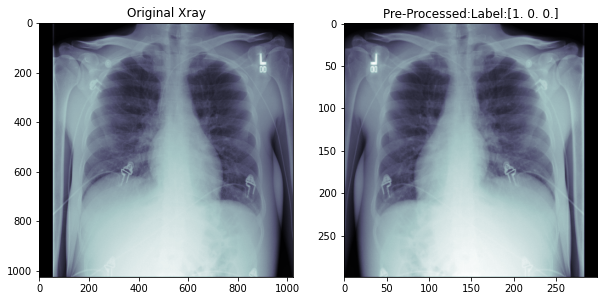

In [ ]:
f, ax = plt.subplots(1, 2, figsize=(10,7))
ax[0].imshow(img, cmap=plt.cm.bone)
ax[0].set_title("Original Xray")
ax[1].imshow(imageSet[SetIndex][:,:,0],cmap=plt.cm.bone)
ax[1].set_title("Pre-Processed:Label:{}".format(maskSet[SetIndex]))
# The images are converted from RGB to BGR, 
#then each color channel is zero-centered with respect to the ImageNet dataset, without scaling.

In [ ]:

def build_pretrained_model():
  #Build base model
  input_shape = MODEL_MAP[BASE_MODEL]['input_shape']
  base_pretrained_model = BaseModel(input_shape =  input_shape, 
                              include_top = False, weights = 'imagenet')
  base_pretrained_model.trainable = False
  #Build Top layer
  lastlayer = MODEL_MAP[BASE_MODEL]['last_conv_layer']
  lastlayershape = base_pretrained_model.get_layer(lastlayer).output_shape[1:]
  pt_features = Input(lastlayershape, name = 'feature_input')
    
  bn_features = BatchNormalization()(pt_features)
  gap = GlobalAveragePooling2D()(bn_features)

  gap_dr = Dropout(DROPOUT)(gap)
  dr_steps = Dropout(DROPOUT)(Dense(DENSE_COUNT, activation = 'linear', use_bias=False)(gap_dr))
  dr_steps = BatchNormalization()(dr_steps)
  dr_steps = layers.LeakyReLU(0.1)(dr_steps)
  out_layer = Dense(3, activation = 'softmax')(dr_steps)

  attn_model = Model(inputs = [pt_features], 
                    outputs = [out_layer], name = 'top_model')
  #Combine base & top model
  pneu_model = Sequential(name = 'combined_model')
  # base_pretrained_model.trainable = False
  pneu_model.add(base_pretrained_model)
  pneu_model.add(attn_model)
  #Add loss & optimizer
  lr = LEARN_RATE
  decay = lr/10 # or in the factor of 10
  adamOptimizer = Adam(lr=lr, beta_1=0.9, beta_2=0.999, epsilon=None, decay=decay, amsgrad=False)
  pneu_model.compile(optimizer =adamOptimizer, loss = 'categorical_crossentropy',
                           metrics = ['categorical_accuracy'])
  
  return pneu_model,base_pretrained_model,attn_model

In [ ]:
class_model,base_model,top_model = build_pretrained_model()
class_model.summary()

219062272/219055592 [==============================] - 1s 0us/step
Model: "combined_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Functio (None, 8, 8, 1536)        54336736  
_________________________________________________________________
top_model (Functional)       (None, 3)                 203651    
Total params: 54,540,387
Trainable params: 200,323
Non-trainable params: 54,340,064
_________________________________________________________________


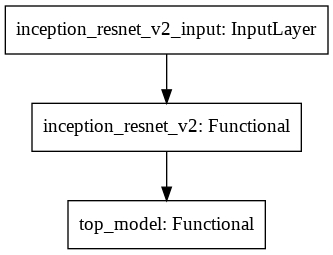

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(class_model)

In [ ]:
checkpoint = ModelCheckpoint(WEIGHTS_FILE, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.2, 
                                   patience=3, verbose=1, mode='auto', 
                                   epsilon=0.0001, cooldown=5, min_lr=0.0001)
early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=3) 
callbacks_list = [checkpoint, early, reduceLROnPlat]

##Model Fit

In [ ]:
%%time
history = pd.DataFrame()
FORCE_TRAINING = True
if (os.path.isfile(WEIGHTS_FILE) & (FORCE_TRAINING == False) ):
  class_model.load_weights(WEIGHTS_FILE)
  history = loadHistory(HISTORY_FILE)
else:
  if (os.path.isfile(WEIGHTS_FILE)):
    class_model.load_weights(WEIGHTS_FILE)
  history = class_model.fit(train_gen,   # (X_train, y_train)
                        epochs=EPOCHS,
                        validation_data=valid_gen,#(X_valid, y_valid)
                        callbacks=callbacks_list,
                        shuffle=True,
                        verbose=1)
  
  history = saveHistory(history,HISTORY_FILE)

Epoch 1/6
394/394 [==============================] - ETA: 0s - loss: 0.9643 - categorical_accuracy: 0.5583 
Epoch 00001: val_loss improved from inf to 0.83123, saving model to Option-1.InceptionResNetV2/weights.best_299_final1.h5
394/394 [==============================] - 9782s 25s/step - loss: 0.9643 - categorical_accuracy: 0.5583 - val_loss: 0.8312 - val_categorical_accuracy: 0.6077
Epoch 2/6
394/394 [==============================] - ETA: 0s - loss: 0.8548 - categorical_accuracy: 0.6053
Epoch 00002: val_loss improved from 0.83123 to 0.79579, saving model to Option-1.InceptionResNetV2/weights.best_299_final1.h5
394/394 [==============================] - 393s 998ms/step - loss: 0.8548 - categorical_accuracy: 0.6053 - val_loss: 0.7958 - val_categorical_accuracy: 0.6216
Epoch 3/6
394/394 [==============================] - ETA: 0s - loss: 0.8181 - categorical_accuracy: 0.6234
Epoch 00003: val_loss improved from 0.79579 to 0.78711, saving model to Option-1.InceptionResNetV2/weights.best_2

## History

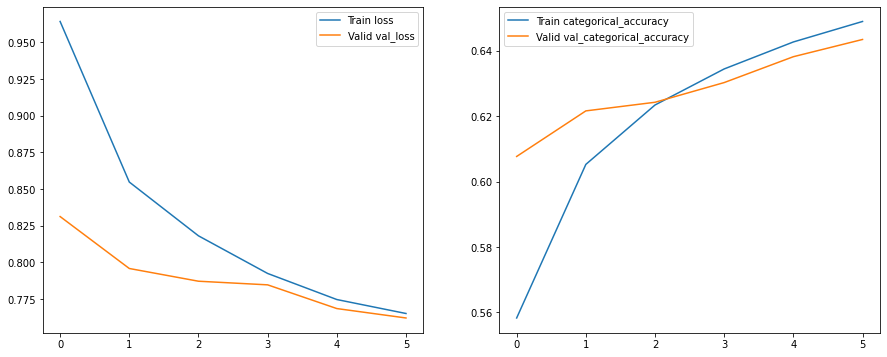

In [ ]:
plot_his(history,'categorical_accuracy')
#Save the model as well for future use

## Classification-Stage1 performance

In [ ]:
# FORCE_TRAINING = False
patients= []
pred_Y= []
valid_Y = []
if (os.path.isfile(PREDICTION_FILE) & (FORCE_TRAINING == False) ):
  file = open(PREDICTION_FILE, 'rb')
  patients = pickle.load(file)
  pred_Y = pickle.load(file)
  valid_Y = pickle.load(file)
  file.close()
else:
  predict_gen = MyLabelTestDataGenerator(train_df)
  patients, pred_Y,valid_Y = class_predict(predict_gen,class_model,no_of_batch=0)
  file = open(PREDICTION_FILE,'wb')
  pickle.dump(patients, file)
  pickle.dump(pred_Y, file)
  pickle.dump(valid_Y, file)
  file.close()


  0%|          | 0/395 [00:00<?, ?it/s]

12624 :No of generator Image


100%|██████████| 395/395 [1:22:09<00:00, 12.48s/it]


In [ ]:
predict_gen = MyLabelTestDataGenerator(test_df)
test_patients, test_pred_Y, test_Y = class_predict(predict_gen,class_model,no_of_batch=0)

  0%|          | 0/84 [00:00<?, ?it/s]

2669 :No of generator Image


100%|██████████| 84/84 [16:26<00:00, 11.74s/it]


[[2876  987  345]
 [1053 2195  960]
 [ 106  486 3616]]
                              precision    recall  f1-score   support

                Lung Opacity       0.71      0.68      0.70      4208
No Lung Opacity / Not Normal       0.60      0.52      0.56      4208
                      Normal       0.73      0.86      0.79      4208

                    accuracy                           0.69     12624
                   macro avg       0.68      0.69      0.68     12624
                weighted avg       0.68      0.69      0.68     12624



Text(0, 0.5, 'True')

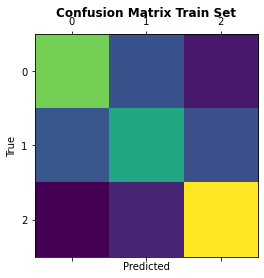

In [ ]:
from sklearn.metrics import confusion_matrix
plt.matshow(confusion_matrix(np.argmax(valid_Y, -1), np.argmax(pred_Y,-1)))
print(confusion_matrix(np.argmax(valid_Y, -1), np.argmax(pred_Y,-1)))
print(classification_report(np.argmax(valid_Y, -1), 
                            np.argmax(pred_Y,-1), target_names = class_enc.classes_))
plt.title('Confusion Matrix Train Set', fontsize = 12, fontweight="bold")
plt.xlabel('Predicted')
plt.ylabel('True')



[[391 163  48]
 [335 543 304]
 [ 19 136 730]]
                              precision    recall  f1-score   support

                Lung Opacity       0.52      0.65      0.58       602
No Lung Opacity / Not Normal       0.64      0.46      0.54      1182
                      Normal       0.67      0.82      0.74       885

                    accuracy                           0.62      2669
                   macro avg       0.61      0.64      0.62      2669
                weighted avg       0.63      0.62      0.61      2669



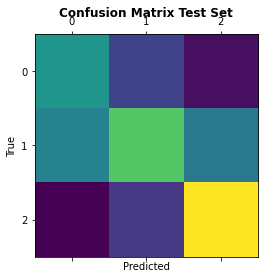

In [ ]:
from sklearn.metrics import confusion_matrix
plt.matshow(confusion_matrix(np.argmax(test_Y, -1), np.argmax(test_pred_Y,-1)))
print(confusion_matrix(np.argmax(test_Y, -1), np.argmax(test_pred_Y,-1)))
print(classification_report(np.argmax(test_Y, -1), np.argmax(test_pred_Y,-1), target_names = class_enc.classes_))
plt.title('Confusion Matrix Test Set', fontsize = 12, fontweight="bold")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

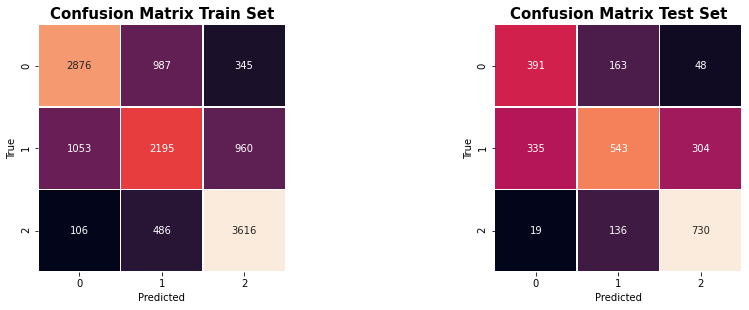

In [ ]:
import seaborn as sns
plt.figure(figsize= (15,10))
plt.subplot(2,2,1)

mat = metrics.confusion_matrix(np.argmax(valid_Y, -1), np.argmax(pred_Y,-1))
sns.heatmap(mat, square=True, annot = True, fmt = 'd', cbar = False, linewidth=0.5)
plt.title('Confusion Matrix Train Set', fontsize = 15, fontweight="bold")
plt.xlabel('Predicted')
plt.ylabel('True')

plt.subplot(2,2,2)
mat = metrics.confusion_matrix(np.argmax(test_Y, -1), np.argmax(test_pred_Y,-1))
sns.heatmap(mat, square=True, annot = True, fmt = 'd', cbar = False, linewidth=0.5)
plt.title('Confusion Matrix Test Set', fontsize = 15, fontweight="bold")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

### ROC AUC

In [ ]:
type(valid_Y[0])

numpy.ndarray

In [ ]:
np.argmax(valid_Y,-1)==0

array([ True, False, False, ..., False, False, False])

In [ ]:
# from sklearn.metrics import roc_curve, roc_auc_score
# fpr, tpr, _ = roc_curve(np.argmax(valid_Y,-1)==0, pred_Y)
# fig, ax1 = plt.subplots(1,1, figsize = (5, 5), dpi = 250)
# ax1.plot(fpr, tpr, 'b.-', label = 'DenseNet1 (AUC:%2.2f)' % roc_auc_score(np.argmax(valid_Y,-1)==0, pred_Y))
# ax1.plot(fpr, fpr, 'k-', label = 'Random Guessing')
# ax1.legend(loc = 4)
# ax1.set_xlabel('False Positive Rate')
# ax1.set_ylabel('True Positive Rate');
# ax1.set_title('Lung Opacity ROC Curve')

## Generate class prediction

In [ ]:
pred_df = get_prediction_map(patients,pred_Y)

In [ ]:
pred_df.reset_index(inplace=True)
# pred_df.columns = ['patientId', 'PNEUMONIA', 'NOT_NORMAL', 'NORMAL']

pred_df.rename(columns={'index':'patientId'},inplace=True)
pred_df.head()

,patientId,PNEUMONIA,NOT_NORMAL,NORMAL
0,b70a7d7e-3e11-4a74-998f-67eabfa438df,0.132451,0.471456,0.396093
1,d131669f-1cac-49a0-b432-f3ca8671d38e,0.104886,0.405995,0.489118
2,b7d5bd44-6d2f-433d-be65-4d7a7759864f,0.042786,0.204316,0.752898
3,83eeeb49-96b9-455a-89ab-425a0e5c471f,0.024896,0.143794,0.831310
4,ec34aed1-86f5-4426-b68e-2fd5e95482b0,0.007525,0.092058,0.900418


In [ ]:
pred_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12624 entries, 0 to 12623
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   patientId   12624 non-null  object 
 1   PNEUMONIA   12624 non-null  float64
 2   NOT_NORMAL  12624 non-null  float64
 3   NORMAL      12624 non-null  float64
dtypes: float64(3), object(1)
memory usage: 394.6+ KB


In [ ]:
pred_dump_file = MODEL_NAME + '/class_prediction_299.csv'
if (os.path.isfile(pred_dump_file)):
  os.remove(pred_dump_file)

In [ ]:
#Dump the prediction as it is very time consuming task.

import pandas as pd

if (os.path.isfile(pred_dump_file)):
  global pred_df
  pred_df = pd.read_csv(pred_dump_file)
else:
  pred_df.to_csv(pred_dump_file,index=False)

In [ ]:
# pred_df.drop(pred_df.columns[0],inplace=True,axis=1)

In [ ]:
merged_pred_meta_df = get_pred_merged_meta_data(pred_df,full_df)
merged_pred_meta_df.head()

,PNEUMONIA,NOT_NORMAL,NORMAL,PatientAge,PatientSex,ViewPosition,Target
b70a7d7e-3e11-4a74-998f-67eabfa438df,0.132451,0.471456,0.396093,37.0,1.0,1.0,1.0
d131669f-1cac-49a0-b432-f3ca8671d38e,0.104886,0.405995,0.489118,70.0,1.0,0.0,0.0
b7d5bd44-6d2f-433d-be65-4d7a7759864f,0.042786,0.204316,0.752898,67.0,0.0,0.0,0.0
83eeeb49-96b9-455a-89ab-425a0e5c471f,0.024896,0.143794,0.831310,44.0,1.0,0.0,0.0
ec34aed1-86f5-4426-b68e-2fd5e95482b0,0.007525,0.092058,0.900418,72.0,1.0,0.0,0.0


In [ ]:
merged_pred_meta_df.reset_index(inplace=True)
merged_pred_meta_df.rename(columns={'index':'patientId'},inplace=True)
merged_pred_meta_df.head()

,patientId,PNEUMONIA,NOT_NORMAL,NORMAL,PatientAge,PatientSex,ViewPosition,Target
0,b70a7d7e-3e11-4a74-998f-67eabfa438df,0.132451,0.471456,0.396093,37.0,1.0,1.0,1.0
1,d131669f-1cac-49a0-b432-f3ca8671d38e,0.104886,0.405995,0.489118,70.0,1.0,0.0,0.0
2,b7d5bd44-6d2f-433d-be65-4d7a7759864f,0.042786,0.204316,0.752898,67.0,0.0,0.0,0.0
3,83eeeb49-96b9-455a-89ab-425a0e5c471f,0.024896,0.143794,0.831310,44.0,1.0,0.0,0.0
4,ec34aed1-86f5-4426-b68e-2fd5e95482b0,0.007525,0.092058,0.900418,72.0,1.0,0.0,0.0


In [ ]:
merged_pred_meta_df[merged_pred_meta_df.Target==1].sample(5)

,patientId,PNEUMONIA,NOT_NORMAL,NORMAL,PatientAge,PatientSex,ViewPosition,Target
11654,3f151141-a3bb-47aa-a213-4a90e8c55502,0.574271,0.365365,0.060365,40.0,1.0,1.0,1.0
9653,b20b2346-f86c-45b5-aeea-a4b10e35b764,0.642567,0.354736,0.002698,52.0,1.0,1.0,1.0
10263,6dec415e-7e38-493d-b5e3-bd8bbb476984,0.960472,0.039281,0.000247,31.0,1.0,1.0,1.0
5448,67b8ef8a-5285-4eec-88c8-8f4fe53f0f6e,0.354801,0.579647,0.065553,32.0,1.0,1.0,1.0
974,b2ea9c20-0653-4f5b-91ae-d91d7ff91339,0.057739,0.054403,0.887858,32.0,1.0,0.0,1.0


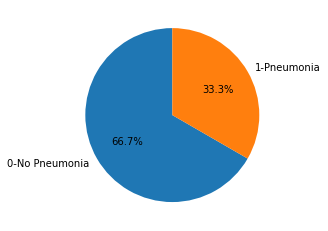

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
unique_values, count = np.unique(merged_pred_meta_df['Target'], return_counts=True)

plt.pie(count, labels = ['0-No Pneumonia', '1-Pneumonia'],
          autopct='%1.1f%%', startangle=90)
plt.show()
#Need to balance the data here.

In [ ]:
#Split the data into train & valid
y = merged_pred_meta_df['Target'].to_numpy()
X = merged_pred_meta_df[merged_pred_meta_df.columns[1:7]]

In [ ]:
X.head()

,PNEUMONIA,NOT_NORMAL,NORMAL,PatientAge,PatientSex,ViewPosition
0,0.132451,0.471456,0.396093,37.0,1.0,1.0
1,0.104886,0.405995,0.489118,70.0,1.0,0.0
2,0.042786,0.204316,0.752898,67.0,0.0,0.0
3,0.024896,0.143794,0.831310,44.0,1.0,0.0
4,0.007525,0.092058,0.900418,72.0,1.0,0.0


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42)

## FFNN model

In [ ]:
#Build neural netwrok

from tensorflow.keras.layers import  Reshape
def add_layer(model):
  kinit ='he_normal' #tf.keras.initializers.he_normal()
  actv = 'relu' #activation.relu
  # model.add(Reshape((6,),input_shape=(32,32,)))
  # #Add batch normalization to avoid NAN in training loss
  # model.add(kl.normalization.BatchNormalization())
  #Add input layer -- 
  model.add(Dense(6,input_dim= 6,activation=actv,kernel_initializer=kinit))
  model.add(BatchNormalization())
  #How many hidden layer? No clear rule, trial & error? Literature says, it 3 hidden layer sufficient
  #Add hidden layer -1
  model.add(Dense(16,activation=actv,kernel_initializer=kinit))
  model.add(BatchNormalization())
  #Add hidden layer -2
  model.add(Dense(8,activation=actv,kernel_initializer=kinit))
  model.add(BatchNormalization())
  #Add hidden layer -3
  model.add(Dense(4,activation=actv,kernel_initializer=kinit))
  model.add(BatchNormalization())


  #Add output layer -- number of output neoron 1(as the number of output is 10)
  #Add hidden layer -1
  model.add(Dense(1,activation='sigmoid',kernel_initializer=kinit))
  
nn_model = Sequential()
add_layer(nn_model)

In [ ]:
def fit_model(opt,model,epoch=60,verbo=1,batchsize=128):
  model.compile(optimizer = opt, loss = 'binary_crossentropy', metrics = ['accuracy'])
  history = model.fit(X_train, y_train, validation_data=(X_test,y_test),batch_size=batchsize, epochs=epoch, verbose=verbo)
  return history
opt = Adam(lr = LEARN_RATE)
history = fit_model(opt,nn_model)

Epoch 1/60
89/89 [==============================] - 1s 8ms/step - loss: 0.8010 - accuracy: 0.4733 - val_loss: 0.7303 - val_accuracy: 0.3840
Epoch 2/60
89/89 [==============================] - 0s 5ms/step - loss: 0.7694 - accuracy: 0.4735 - val_loss: 0.7404 - val_accuracy: 0.4133
Epoch 3/60
89/89 [==============================] - 1s 6ms/step - loss: 0.7406 - accuracy: 0.4702 - val_loss: 0.7361 - val_accuracy: 0.4434
Epoch 4/60
89/89 [==============================] - 0s 5ms/step - loss: 0.7280 - accuracy: 0.4699 - val_loss: 0.7279 - val_accuracy: 0.4648
Epoch 5/60
89/89 [==============================] - 0s 5ms/step - loss: 0.7162 - accuracy: 0.4717 - val_loss: 0.7229 - val_accuracy: 0.4679
Epoch 6/60
89/89 [==============================] - 1s 6ms/step - loss: 0.7074 - accuracy: 0.4756 - val_loss: 0.7174 - val_accuracy: 0.4648
Epoch 7/60
89/89 [==============================] - 1s 6ms/step - loss: 0.7013 - accuracy: 0.4741 - val_loss: 0.7094 - val_accuracy: 0.4711
Epoch 8/60
89/89 [==

In [ ]:
HISTORY_FILE = MODEL_NAME+"/" +"history_FFNN_final.csv"
his_ffnn = saveHistory(history,HISTORY_FILE)

## Classification Performance(Recall)

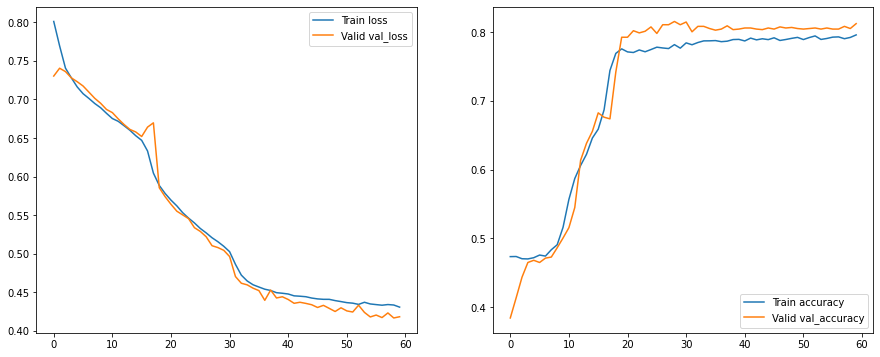

In [ ]:
plot_his(his_ffnn,'accuracy')

In [ ]:
pred_y_train = nn_model.predict(X_train)
pred_y_train_class = (pred_y_train >= 0.45).astype(np.int)

In [ ]:
pred_y = nn_model.predict(X_test)

In [ ]:
pred_y

array([[0.07317542],
       [0.8256282 ],
       [0.07317542],
       ...,
       [0.8256282 ],
       [0.26599845],
       [0.7654261 ]], dtype=float32)

In [ ]:
pred_y_class = (pred_y >= 0.45).astype(np.int)

In [ ]:
y_test = (y_test >= 0.5).astype(np.int)


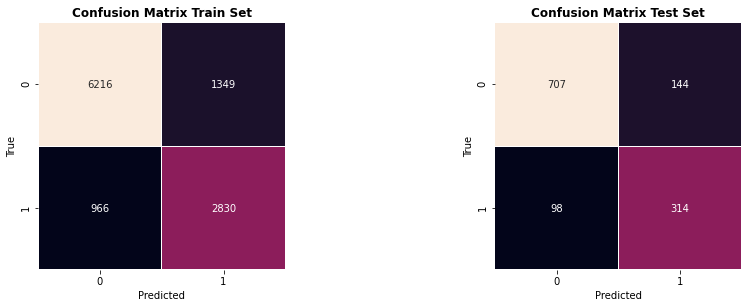

In [ ]:
plt.figure(figsize= (15,10))
plt.subplot(2,2,1)

mat = metrics.confusion_matrix(y_train, pred_y_train_class)
sns.heatmap(mat, square=True, annot = True, fmt = 'd', cbar = False, linewidth=0.5)
plt.title('Confusion Matrix Train Set', fontsize = 12, fontweight="bold")
plt.xlabel('Predicted')
plt.ylabel('True')
#plt.show()

plt.subplot(2,2,2)
mat = metrics.confusion_matrix(y_test, pred_y_class)
sns.heatmap(mat, square=True, annot = True, fmt = 'd', cbar = False, linewidth=0.5)
plt.title('Confusion Matrix Test Set', fontsize = 12, fontweight="bold")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [ ]:
print("Confusion Matrix:- \n", metrics.confusion_matrix(y_train, pred_y_train_class), "\n")
print("Classification Report Test Set:- \n", metrics.classification_report(y_train, pred_y_train_class))

Confusion Matrix:- 
 [[6216 1349]
 [ 966 2830]] 

Classification Report Test Set:- 
               precision    recall  f1-score   support

         0.0       0.87      0.82      0.84      7565
         1.0       0.68      0.75      0.71      3796

    accuracy                           0.80     11361
   macro avg       0.77      0.78      0.78     11361
weighted avg       0.80      0.80      0.80     11361



In [ ]:
print("Confusion Matrix:- \n", metrics.confusion_matrix(y_test, pred_y_class), "\n")
print("Classification Report:- \n", metrics.classification_report(y_test, pred_y_class))

Confusion Matrix:- 
 [[707 144]
 [ 98 314]] 

Classification Report:- 
               precision    recall  f1-score   support

           0       0.88      0.83      0.85       851
           1       0.69      0.76      0.72       412

    accuracy                           0.81      1263
   macro avg       0.78      0.80      0.79      1263
weighted avg       0.82      0.81      0.81      1263



### ROC curve

Text(0.5, 1.0, 'Lung Opacity ROC Curve')

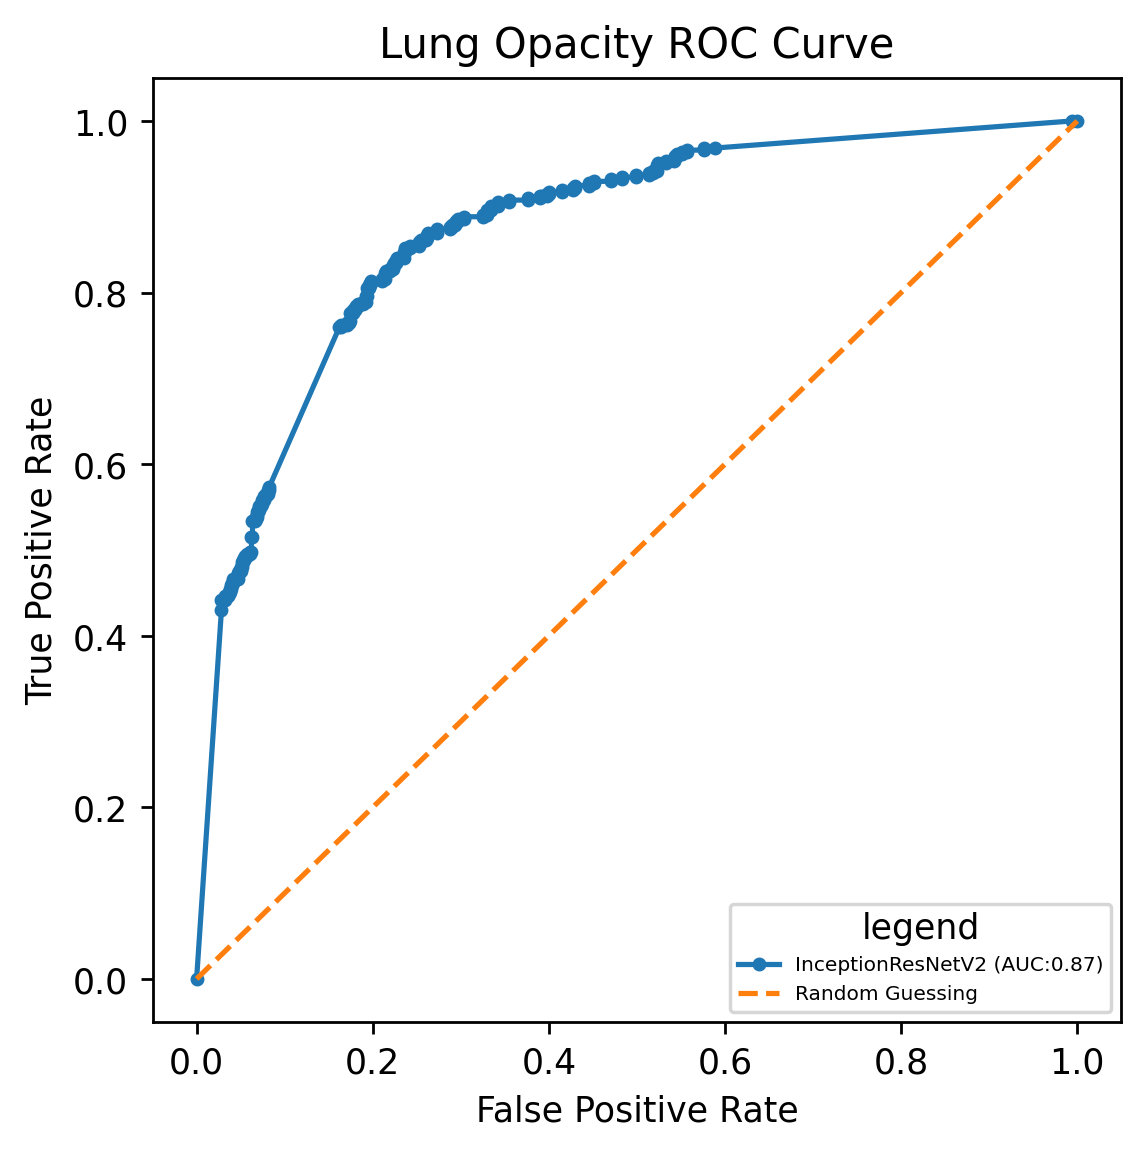

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score
from matplotlib.font_manager import FontProperties
fontP = FontProperties()
fontP.set_size('xx-small')
fpr, tpr, _ = roc_curve(y_test, pred_y)
fig, ax1 = plt.subplots(1,1, figsize = (5, 5), dpi = 250)
ax1.plot(fpr, tpr, marker='.', label = 'InceptionResNetV2 (AUC:%2.2f)' % roc_auc_score(y_test, pred_y))
ax1.plot(fpr, fpr, linestyle='--', label = 'Random Guessing')
ax1.legend(title='legend',  loc='lower right', prop=fontP)
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate');
ax1.set_title('Lung Opacity ROC Curve')

## Conclusion